In [1]:
import os
import pandas as pd
import numpy as np
from quantities import ns, s
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  'you are using the python implementation of fast fca')


In [2]:
def load_data(recording, data_dir, verbose):
    if verbose:
        print('Loading data:\t{}'.format(recording))
    path = ''.join([os.path.join(data_dir, recording), '.csv'])
    return pd.read_csv(path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_time_series(df):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    return df

def get_baseline_stats(df, condition_label, resample_period):
    df = df[df['condition'] == condition_label]
    df = create_ts(df=df,
                   rolling_period=False,
                   resample_period=resample_period)
    condition_means = df.transpose().mean(axis=1)
    condition_stds = df.transpose().std(axis=1)
    condition_sorted = condition_means.sort_values()
    return condition_means, condition_stds, condition_sorted

def create_ts(df, rolling_period, resample_period=1):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    df = df.resample('s').count()
    if rolling_period:
        df = df.rolling(rolling_period).mean()
    return df

def normalise(df, method, condition_means, condition_stds):
    if method == 'zscore':
        def f(col):
            return (col.subtract(condition_means)).divide(condition_stds)
    elif method == 'percent':
        def f(col):
            return col.divide(condition_means) * 100
    elif not method:
        def f(col):
            print('Note: No Normalisation Method Provided')
            return col
    df = df.transpose().apply(f)
    return df

def select_neruon_cat(ts_df, df_all_neurons, recording, category_column, category):
    clusters = df_all_neurons[(df_all_neurons['recording'] == recording) & (df_all_neurons[category_column] == category)]['spike_cluster'].unique()
    return ts_df[ts_df.index.isin(clusters)]

def plot_heatmap_separate_categories(ts_df, df_all_neurons, recording, category_column, vmin, vmax, normalise_method):

    num_categories = len(df_all_neurons['category'].unique())
    f, a = plt.subplots(nrows=num_categories, ncols=1, figsize=(19, 25))

    for index, category in enumerate(df_all_neurons[category_column].unique()):
        df_cat = select_neruon_cat(ts_df=ts_df,
                                   df_all_neurons=df_all_neurons,
                                   recording=recording,
                                   category_column=category_column,
                                   category=category)

        recording_len = df_cat.transpose().index.max().seconds
        x_tick_pos = round(recording_len / 4)

        sns.heatmap(data=df_cat,
                    cmap='coolwarm',
                    vmin=vmin,
                    vmax=vmax,
                    ax=a.flat[index],
                    xticklabels=x_tick_pos,
                    cbar_kws={'label': f'{normalise_method} Baseline mean'})

        a.flat[index].set_xticklabels(list(map(lambda num:
                                               str(round(recording_len / 4 / 60 * num, -1)),
                                               [0, 1, 2, 3])))
        a.flat[index].set_title(category)
    plt.suptitle(recording, fontsize=15)
    plt.tight_layout()
    plt.show()



In [3]:
df = load_data(recording='all_neurons_ts_with_clusters',
                       data_dir=r'E:\CIT_WAY\csvs',
                       verbose=True)
df = manipulate_df(df)

Loading data:	all_neurons_ts_with_clusters


In [4]:
df = df[df['recording']=='2018-05-01_01']
df_base = df[df['condition']=='Baseline']

In [5]:
df_ts_stats = create_time_series(df_base)


In [6]:
df_ts_stats.fillna(0, inplace=True)

In [52]:
def calculate_neuron_mfr(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin.iloc[col_bin.nonzero()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs.fillna(0, inplace=True)
    mfrs *= 10**10
    return mfrs  #differrent from stats

In [26]:
np.sum(df_ts_stats.iloc[:, 0] == 1)

5200

In [57]:
def calculate_neuron_mfr_2(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        num_spikes = np.sum(col_bin == 1)
        if not num_spikes:
            mfr = 0
        else:
            mfr = num_spikes/(num_mins_per_bin*60)
        mfrs[ind] = mfr
    mfrs.fillna(0, inplace=True)
    #mfrs *= 10**10
    return mfrs  #differrent from stats

In [60]:
mfr_base = df_ts_stats.apply(func=calculate_neuron_mfr_2,
                                           num_mins_per_bin=2,
                                           total_time=60)  #returns single value for eacg cluster
#nanstd = df_ts_stats.apply(func=calculate_neuron_mfr_2,num_mins_per_bin=2, total_time=60, np.nanstd)  #r

In [61]:
mfr_base

spike_cluster,0,4,6,9,13,16,17,22,24,26,...,74,83,97,98,99,103,112,113,116,119
0,0.075000,0.550000,0.391667,6.791667,0.191667,0.108333,1.191667,0.008333,0.000000,0.016667,...,0.808333,2.991667,20.016667,0.925000,9.433333,0.050000,11.825000,2.483333,5.291667,8.608333
1,0.058333,1.000000,0.316667,7.650000,0.291667,0.075000,1.716667,0.000000,0.016667,0.000000,...,0.875000,4.866667,16.216667,1.391667,8.425000,0.100000,12.233333,2.691667,1.516667,8.791667
2,0.041667,1.508333,0.250000,6.216667,0.483333,0.016667,2.758333,0.000000,0.025000,0.050000,...,0.591667,3.925000,17.716667,2.608333,7.158333,0.133333,10.275000,2.266667,4.933333,7.316667
3,0.175000,2.116667,0.275000,7.991667,0.075000,0.033333,3.041667,0.000000,0.008333,0.058333,...,0.475000,4.650000,13.566667,1.950000,7.866667,0.133333,11.208333,2.750000,3.383333,8.116667
4,0.100000,2.858333,0.483333,7.950000,0.116667,0.033333,3.083333,0.000000,0.016667,0.058333,...,0.575000,4.850000,13.125000,1.616667,8.333333,0.158333,11.025000,2.558333,3.808333,8.616667
5,0.100000,3.633333,0.458333,7.408333,0.125000,0.041667,2.650000,0.000000,0.025000,0.025000,...,0.616667,4.408333,15.300000,1.425000,8.483333,0.141667,10.775000,2.733333,2.400000,8.825000
6,0.166667,4.516667,0.608333,6.191667,0.100000,0.025000,3.083333,0.000000,0.050000,0.183333,...,1.050000,4.800000,13.383333,1.466667,8.975000,0.258333,10.816667,2.966667,1.100000,9.141667
7,0.325000,4.283333,0.625000,5.833333,0.325000,0.066667,3.800000,0.425000,0.016667,0.733333,...,0.858333,4.091667,8.783333,1.641667,8.666667,0.391667,10.991667,2.891667,1.075000,8.916667
8,1.166667,2.466667,1.233333,7.808333,1.991667,0.025000,3.608333,2.133333,3.325000,0.366667,...,0.341667,0.725000,5.558333,1.933333,6.650000,0.616667,5.550000,5.108333,8.375000,7.200000
9,1.708333,1.616667,1.491667,5.925000,2.908333,0.008333,3.225000,2.366667,1.441667,1.566667,...,0.458333,0.383333,7.650000,1.916667,5.883333,0.916667,3.275000,6.441667,7.083333,6.408333


In [54]:
test_base = df_ts_stats.apply(func=calculate_neuron_mfr,
                                           num_mins_per_bin=2,
                                           total_time=60)

In [55]:
test_base 

spike_cluster,0,4,6,9,13,16,17,22,24,26,...,74,83,97,98,99,103,112,113,116,119
0,0.802428,4.438710,3.134260,53.719782,1.646927,0.923656,9.416295,0.127468,0.000000,0.192516,...,6.460317,23.670891,158.223125,7.489063,74.532084,0.460585,93.440548,19.704564,42.341736,68.048915
1,0.252561,3.763168,1.210724,28.768033,1.108378,0.284123,6.451048,0.000000,0.065759,0.000000,...,3.293344,18.289083,60.956898,5.240622,31.659027,0.408796,45.982791,10.121704,5.701868,33.037671
2,0.114589,3.883610,0.645857,15.981875,1.255702,0.052208,7.091621,0.000000,0.064621,0.134513,...,1.538685,10.091829,45.542563,6.717070,18.403879,0.347076,26.418111,5.831973,12.698155,18.809513
3,0.334372,4.031860,0.524668,15.215270,0.147244,0.063766,5.795542,0.000000,0.021136,0.113839,...,0.905896,8.856072,25.831388,3.718017,14.979152,0.261045,21.340378,5.238465,6.441606,15.455352
4,0.151350,4.298781,0.729100,11.947959,0.175464,0.054889,4.636392,0.000000,0.029081,0.088835,...,0.865420,7.290401,19.727488,2.429842,12.526338,0.241798,16.570758,3.845749,5.723563,12.949714
5,0.124726,4.517787,0.572285,9.210043,0.155883,0.053540,3.297249,0.000000,0.033251,0.031843,...,0.766464,5.478986,19.016467,1.774484,10.545453,0.179261,13.395291,3.397858,2.984120,10.970991
6,0.175438,4.718574,0.635659,6.468918,0.104874,0.027204,3.226685,0.000000,0.052590,0.193608,...,1.097689,5.013477,13.981012,1.532924,9.374565,0.270026,11.297829,3.098874,1.149358,9.548727
7,0.293439,3.867744,0.564516,5.273307,0.293457,0.061082,3.431285,0.383765,0.015138,0.662107,...,0.775021,3.695151,7.930247,1.482462,7.824760,0.353608,9.925545,2.610833,0.971770,8.050396
8,0.962114,2.034681,1.017166,6.440514,1.642813,0.021691,2.975945,1.760081,2.758795,0.302379,...,0.283202,0.598875,4.583810,1.594603,5.483761,0.508540,4.580288,4.212689,6.909080,5.939332
9,1.305646,1.235572,1.140275,4.528369,2.222906,0.006753,2.464978,1.809193,1.102118,1.198186,...,0.350951,0.293709,5.846603,1.465225,4.496779,0.700637,2.503667,4.923096,5.413483,4.897564


In [34]:
mfr_base

spike_cluster
0       1.444444
4       1.708056
6       1.152778
9       6.633056
13      2.032500
16      0.063889
17      3.487778
22      1.365000
24      2.360556
26      0.281944
27      0.616944
31      0.451944
32      1.358889
33      0.206667
51      1.506667
57      1.206944
59      1.736944
71      0.718333
73      1.830833
74      0.547778
83      1.219167
97     10.164167
98      2.778889
99      5.928889
103     1.859722
112     4.958333
113     5.000833
116     5.403333
119     6.598333
dtype: float64

In [35]:
df_rec = create_ts(df=df,
                           resample_period='1sec',
                           rolling_period=120)

In [36]:
df_rec = normalise(df=df_rec,
                           method='zscore',
                           condition_means=mfr_base,
                           condition_stds=nanstd)

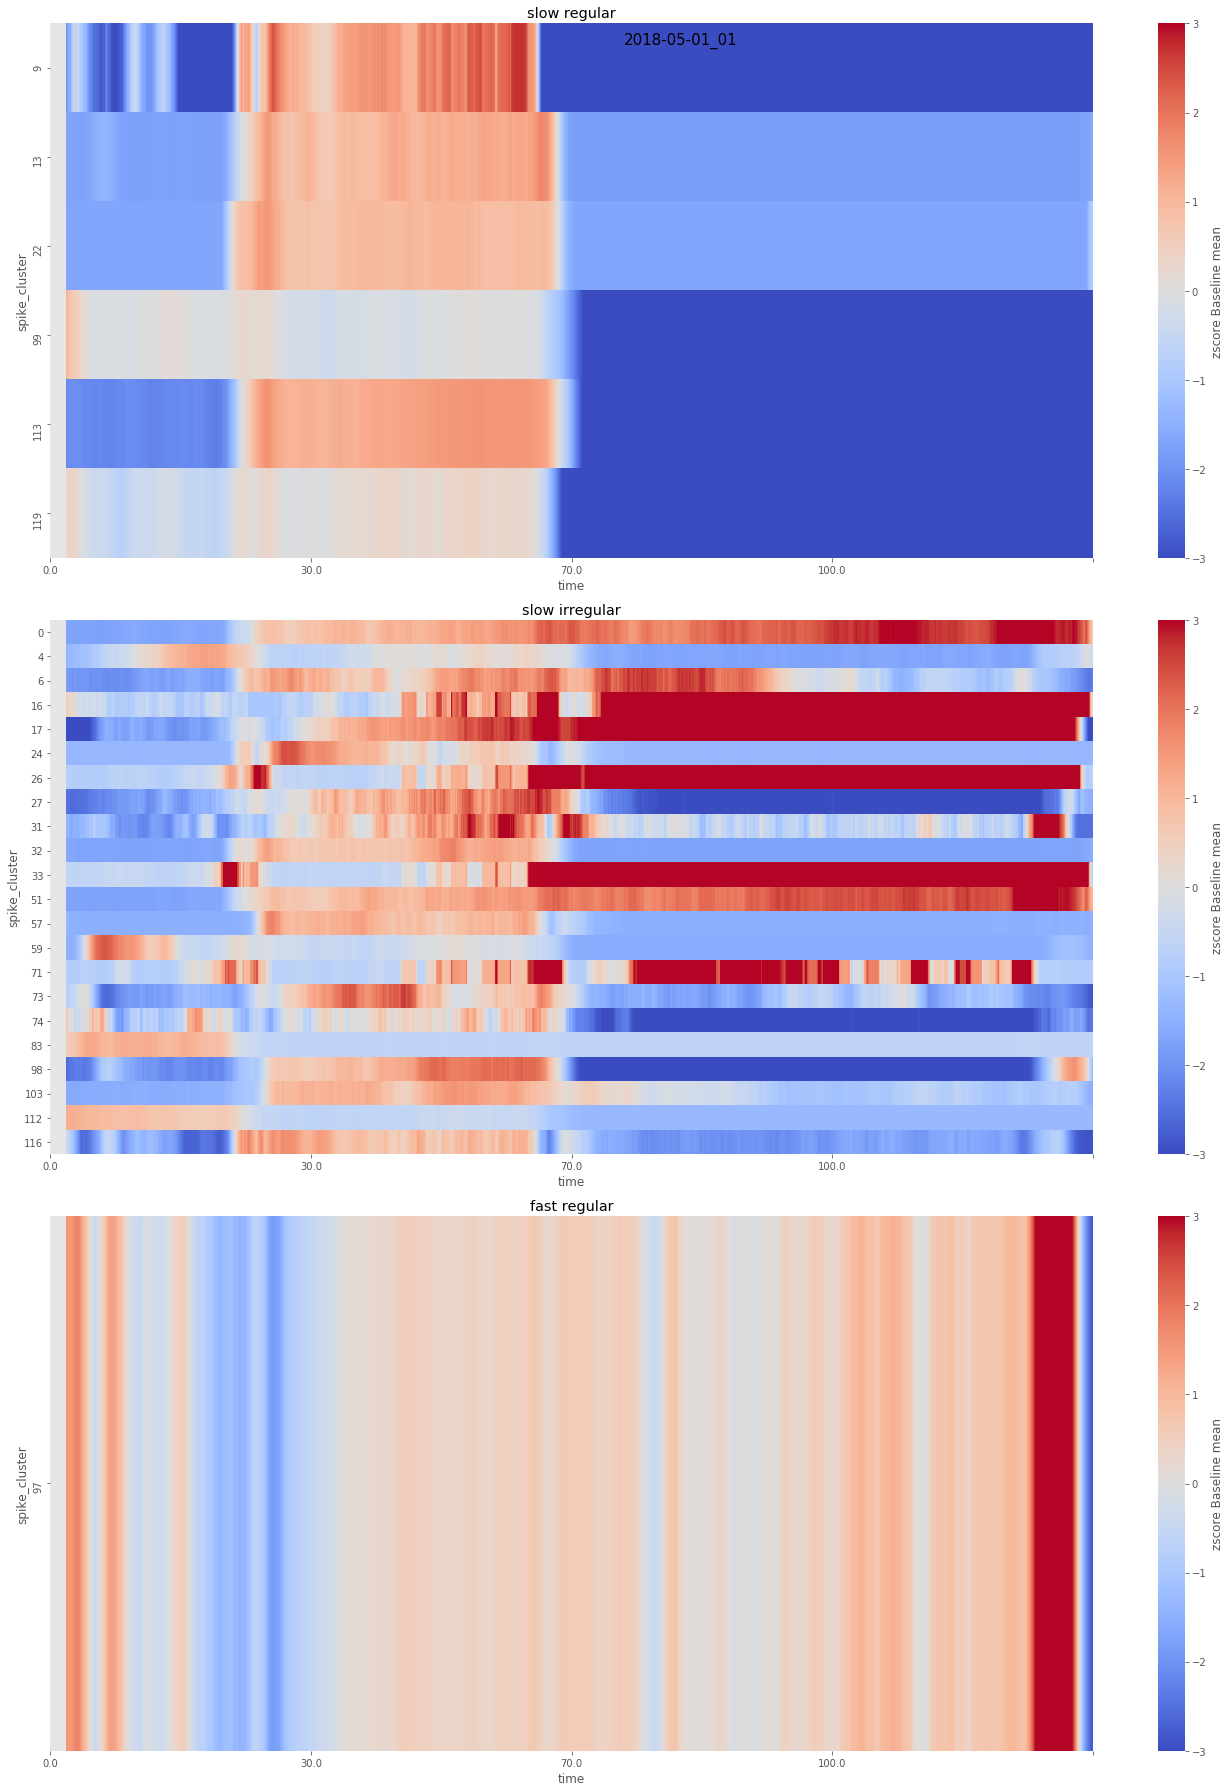

In [37]:
plot_heatmap_separate_categories(ts_df=df_rec,
                                         df_all_neurons=df,
                                         recording='2018-05-01_01',
                                         category_column='category',
                                         vmin=-3, vmax=3,
                                         normalise_method='zscore')

In [39]:
np.linspace(0, 29, 30)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [ ]:
base_means, base_stds, base_sorted = get_baseline_stats(df=df,
                                                                condition_label='Baseline',
                                                                resample_period='120sec')

In [ ]:
cno_mean, cno_stds, cno_sorted = get_baseline_stats(df=df,
                                                                condition_label='CNO',
                                                                resample_period='120sec')

In [ ]:
pd.DataFrame({'Baseline': base_means, 'CNO': cno_mean})

In [ ]:
df_ts.iloc[:, 1:2].apply(calculate_neuron_mfr, num_mins_per_bin=2, total_time=60)

In [ ]:
df_ts.apply(calculate_neuron_mfr).head()

In [ ]:
df_base = df[df['condition']=='Baseline']
df_ts = create_ts(df = df, rolling_period=5, resample_period='120sec')
mean_firing_rates_ts = df_ts.apply(func=calculate_neuron_mfr,
                                           num_mins_per_bin=2,
                                           total_time=60, axis=0)

In [ ]:
mean_firing_rates_ts

In [ ]:
df_ts

In [ ]:
df_cno_base = df[df['condition'] == 'CNO']
df_cno_ts = create_ts(df = df_cno_base, rolling_period=5, resample_period='120sec')
cno_mean_firing_rates_ts = df_cno_ts.apply(func=calculate_neuron_mfr,
                                           num_mins_per_bin=2,
                                           total_time=60)

In [ ]:
mean_firing_rates_ts.fillna(value=0, inplace=True)
cno_mean_firing_rates_ts.fillna(value=0, inplace=True)

## Check for assumptions before conducting t-test

### Assumption: There's no sigificant outlier within the group

In [ ]:
cluster = 88

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].boxplot(mean_firing_rates_ts.loc[:,cluster])
ax[0].title.set_text('Baseline')
ax[1].boxplot(cno_mean_firing_rates_ts.loc[:,cluster])
ax[1].title.set_text('CNO')
plt.show()

##### Check for outliers. Outliers are defined as data points outside standard deviation

In [ ]:
def outliers(tmp):
    """tmp is a list of numbers"""
    outs = []
    mean = sum(tmp)/(1.0*len(tmp))
    var = sum((tmp[i] - mean)**2 for i in range(0, len(tmp)))/(1.0*len(tmp))
    std = var**0.5
    outs = [tmp[i] for i in range(0, len(tmp)) if abs(tmp[i]-mean) > 1.96*std]
    return outs


print(outliers(cno_mean_firing_rates_ts.loc[:,cluster]))

### Assumption: The distribution of the two groups should follow the normal distribution

#### Method 1: Just eyeball it using histogram

In [ ]:
difference_before_after = mean_firing_rates_ts.loc[:,cluster] - cno_mean_firing_rates_ts.loc[:,cluster]
difference_before_after.plot(kind='hist', title= 'Difference Histogram')

#### Method 2 (A lil bit more sophisticated): Using Q-Q plot. 

##### Data points far off of the red line indicate deviations from normality.

In [ ]:
stats.probplot(difference_before_after, dist="norm", plot= plt)
plt.title("Baseline mfr Q-Q Plot")

### Method 3 (looking for the holy p value): Shapiro-Wilk test for normality 

##### The second value of the output is the p value. p value < 0.05 indicates violation of the assumption

In [ ]:
stats.shapiro(difference_before_after)

## The data set (amazingly) failed every single assumption щ(゜ロ゜щ). 

### Let's use non-parametric test instead

##### p value < 0.05 is statistically significant. If significant, reject H0

##### Null hypothesis is: "Citalopram did not cause any change in the firing rate"

In [ ]:
stats.mannwhitneyu(mean_firing_rates_ts.loc[:,cluster], cno_mean_firing_rates_ts.loc[:,cluster])

In [ ]:
pd.DataFrame({'Baseline':mean_firing_rates_ts.loc[:,cluster], 'CNO':cno_mean_firing_rates_ts.loc[:,cluster]})

### Good! Now, put it in a loop

In [ ]:
def outliers(tmp):
    """tmp is a list of numbers"""
    outs = []
    mean = sum(tmp)/(1.0*len(tmp))
    var = sum((tmp[i] - mean)**2 for i in range(0, len(tmp)))/(1.0*len(tmp))
    std = var**0.5
    outs = [tmp[i] for i in range(0, len(tmp)) if abs(tmp[i]-mean) > 1.96*std]
    return outs

def check_assumption(cno_mean_firing_rates_ts, mean_firing_rates_ts, cluster):
    outlier_list_cno = outliers(cno_mean_firing_rates_ts.loc[:,cluster])
    outlier_list_base = outliers(mean_firing_rates_ts.loc[:,cluster])
    difference_before_after = mean_firing_rates_ts.loc[:,cluster] - cno_mean_firing_rates_ts.loc[:,cluster]
    normality_p_value = stats.shapiro(difference_before_after)
    if (outlier_list_cno) or (outlier_list_base) or (normality_p_value[1]<0.05):
        assumption = 'False'
    else:
        assumption = 'True'
    return assumption

def check_if_significant(df):
    if df['p value'] < 0.05:
        df['effect'] = 'reacted'
    else:
        df['effect'] = 'not reacted'
    return df

In [ ]:
len(cno_mean_firing_rates_ts.columns)**(.5)

In [ ]:
p_value_list = []
z_value_list = []
for cluster in cno_mean_firing_rates_ts.columns:
    assumption = check_assumption(cno_mean_firing_rates_ts = cno_mean_firing_rates_ts, mean_firing_rates_ts = mean_firing_rates_ts, cluster = cluster)
    if assumption == 'False':
        p_value = stats.mannwhitneyu(mean_firing_rates_ts.loc[:,cluster], cno_mean_firing_rates_ts.loc[:,cluster])[1]
        z_value = stats.mannwhitneyu(mean_firing_rates_ts.loc[:,cluster], cno_mean_firing_rates_ts.loc[:,cluster])[0]/(len(cno_mean_firing_rates_ts.columns)**(.5))
    if assumption == 'True':
        p_value = stats.ttest_rel(mean_firing_rates_ts.loc[:,cluster], cno_mean_firing_rates_ts.loc[:,cluster])
    p_value_list.append(p_value)
    z_value_list.append(z_value)
df_category = pd.DataFrame({'p value': p_value_list, 'spike_cluster':cno_mean_firing_rates_ts.columns, 'effect size': z_value_list})
df_category = df_category.apply(check_if_significant, axis = 1)
df_category.set_index('spike_cluster')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set()


def load_data(path, csv_file_name):
    if not csv_file_name.endswith('.csv'):
        csv_file_name = ''.join([csv_file_name, '.csv'])
    file_path = os.path.join(path, csv_file_name)
    return pd.read_csv(file_path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_ts(df, rolling_period, resample_period=1):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    df = df.resample('s').count()
    if rolling_period:
        df = df.rolling(rolling_period).mean()
    return df

def calculate_neuron_mfr(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs *= 10**10
    return mfrs


def get_baseline_stats(df, condition_label, resample_period):
    df = df[df['condition'] == condition_label]
    df = create_ts(df=df,
                   rolling_period=False,
                   resample_period=resample_period)
    condition_means = df.transpose().mean(axis=1)
    condition_stds = df.transpose().std(axis=1)
    condition_sorted = condition_means.sort_values()
    return condition_means, condition_stds, condition_sorted


def normalise(df, method, condition_means, condition_stds, condition_sorted):
    if method == 'zscore':
        def f(col):
            return (col.subtract(condition_means)).divide(condition_stds)
    elif method == 'percent':
        def f(col):
            return col.divide(condition_means) * 100
    elif not method:
        def f(col):
            print('Note: No Normalisation Method Provided')
            return col
    df = df.transpose().apply(f)
    return df.reindex(condition_sorted.index)


def select_neruon_cat(ts_df, df_all_neurons, recording, category_column, category):
    clusters = df_all_neurons[(df_all_neurons['recording'] == recording) & (df_all_neurons[category_column] == category)]['spike_cluster'].unique()
    return ts_df[ts_df.index.isin(clusters)]


def plot_heatmap_separate_categories(ts_df, df_all_neurons, recording, category_column, vmin, vmax, normalise_method):

    num_categories = len(df_all_neurons['category'].unique())
    f, a = plt.subplots(nrows=num_categories, ncols=1, figsize=(19, 25))

    for index, category in enumerate(df_all_neurons[category_column].unique()):
        df_cat = select_neruon_cat(ts_df=ts_df,
                                   df_all_neurons=df_all_neurons,
                                   recording=recording,
                                   category_column=category_column,
                                   category=category)

        recording_len = df_cat.transpose().index.max().seconds
        x_tick_pos = round(recording_len / 4)

        sns.heatmap(data=df_cat,
                    cmap='coolwarm',
                    vmin=vmin,
                    vmax=vmax,
                    ax=a.flat[index],
                    xticklabels=x_tick_pos,
                    cbar_kws={'label': f'{normalise_method} Baseline mean'})

        a.flat[index].set_xticklabels(list(map(lambda num:
                                               str(round(recording_len / 4 / 60 * num, -1)),
                                               [0, 1, 2, 3])))
        a.flat[index].set_title(category)
    plt.suptitle(recording, fontsize=15)
    plt.tight_layout()
    plt.show()


def gen_fig_path(out_folder, recording):
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    return ''.join([os.path.join(out_folder, recording), '.png'])


In [ ]:
df_all_data.loc[:, 'recording'].unique()

In [ ]:
df_all_data = load_data(path=r'F:\SERT_DREAD\Combined_binary_files_probe\csvs',
                            csv_file_name='all_neurons_ts_with_clusters')

df_rec = df_all_data[df_all_data['recording'] == '2018-04-12_371b'].copy()

df_rec = manipulate_df(df=df_rec)
base_means, base_stds, base_sorted = get_baseline_stats(df=df_rec,
                                                                condition_label='Baseline',
                                                                resample_period='120sec')
df_rec = create_ts(df=df_rec,
                           resample_period='120sec',
                           rolling_period=5)

df_rec = df_rec.apply(func=calculate_neuron_mfr,
                                           num_mins_per_bin=2,
                                           total_time=60)

df_rec = normalise(df=df_rec,
                           method='percent',
                           condition_means=base_means,
                           condition_stds=base_stds,
                           condition_sorted=base_sorted)
plot_heatmap_separate_categories(ts_df=df_rec,
                                         df_all_neurons=df_all_data,
                                         recording=recording,
                                         category_column='category',
                                         vmin=0, vmax=200,
                                         normalise_method='percent')
